# Cài đặt và import các thư viện cần thiết

In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xll4_8cx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xll4_8cx
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import cv2
from datasets import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch

# Chia dataset để training model

## Chia dataset cho tập train

In [3]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/train/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", train_images_np.shape)


Kích thước của mảng hình ảnh: (1177, 256, 256, 3)


In [4]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/train/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", train_labels_np.shape)

Kích thước của mảng mặt nạ: (1177, 256, 256)


In [5]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in train_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in train_labels_np],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(dataset_dict)

In [6]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1177
})

## Chia dataset cho tập validation

In [7]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/validation/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", val_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [8]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/validation/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", val_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [9]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in val_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in val_labels_np],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(dataset_dict)

In [10]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

## Chia dataset cho tập test

In [11]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/test/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", test_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [12]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/kaggle/input/otu-2d/OTU_2D/test/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0
        (thresh, img) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", test_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [13]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img).convert('RGB') for img in test_images_np],
    "label": [Image.fromarray(mask).convert('I') for mask in test_labels_np],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(dataset_dict)

In [14]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

# Kiểm tra ảnh và mặt nạ

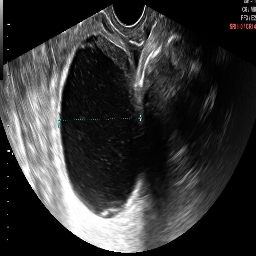

In [15]:
img_num = random.randint(0, train_images_np.shape[0]-1)
example = train_dataset[img_num]
image = example["image"]
image

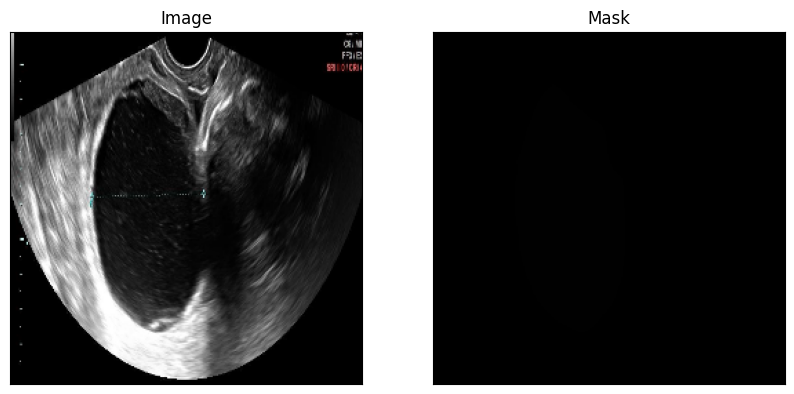

In [16]:
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

(-0.5, 255.5, 255.5, -0.5)

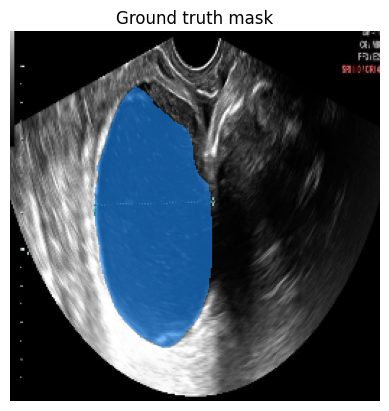

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Vẽ bounding boxes cho mặt nạ

In [18]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# Training Model

## Hàm tạo 1 dataset input images and mask

In [19]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt | vẽ box cho mặt nạ
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model | Chuẩn bị mặt nạ và hộp giới hạn
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default | Loại bỏ chiều Batch được thêm vào mặc định
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation | Thêm ground truth để đánh giá việc Segment sau này, đánh giá hiệu suất mô hình
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

## Load model SAM

### Xử lý dữ liệu để tương thích với đầu vào Model

In [20]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-04-10 07:18:12.767459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 07:18:12.767552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 07:18:12.905291: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [21]:
# Create an instance of the SAMDataseta
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
test_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [22]:
example = train_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [23]:
example = val_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [24]:
example = test_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [25]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, drop_last=False)

In [26]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [27]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [28]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [29]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load model Pretrained của Segment Anything

In [30]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

### Khởi tạo model với hàm tối ưu là Adam, hàm loss là DiceCELoss

In [31]:
import torch.optim as optim
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss

# Khởi tạo optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)

# Sử dụng DiceCELoss
seg_loss = DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# Sử dụng DiceFocalLoss
# seg_loss = DiceFocalLoss(sigmoid=True, gamma=0.25)

# Sử dụng DiceLoss
# seg_loss = DiceLoss(to_onehot_y=True, softmax=True)



### Load hàm loss đánh giá model

In [32]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

smooth=1e-10

# Define functions for calculating evaluation metrics
def dice(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    false_positive = torch.sum(predicted) - true_positive
    return (2. * true_positive + smooth) / (2. *true_positive + false_negative + false_positive + smooth)

def iou(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    return (intersection + smooth) / (union + smooth)

def recall(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    return (true_positive + smooth) / (true_positive + false_negative + smooth)

def precision(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted) - true_positive
    return (true_positive + smooth) / (true_positive + false_positive + smooth)

### Train Model

In [33]:
# model.load_state_dict(torch.load("/kaggle/input/validation-100epochs/checkpoint_SAM/best_model_weights.pt"))

### Early Stopping

In [34]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint
checkpoint_dir = '/kaggle/working/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Add list to record loss of train dataset
train_loss_list = []
train_dice_loss = []
train_iou_loss = []
train_precision_loss = []
train_recall_loss = []

# Add list to record loss of validation dataset
val_loss_list = []
val_dice_loss = []
val_iou_loss = []
val_precision_loss = []
val_recall_loss = []

# Early stopping parameters
patience = 15  # Số lượng epochs mà mô hình không cải thiện trước khi dừng sớm
counter = 0

# Training loop
num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    correct_predictions = 0
    total_predictions = 0
    
    # Train Model on Train Dataset
    epoch_losses = []
    train_dice_scores = []
    train_iou_scores = []
    train_recall_scores = []
    train_precision_scores = []
    
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        predicted_masks_eval = (outputs.pred_masks.squeeze() > 0.5).float() 
        train_dice_scores.append(dice(predicted_masks_eval, ground_truth_masks))
        train_iou_scores.append(iou(predicted_masks_eval, ground_truth_masks))
        train_recall_scores.append(recall(predicted_masks_eval, ground_truth_masks))
        train_precision_scores.append(precision(predicted_masks_eval, ground_truth_masks))

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    if epoch == num_epochs - 1:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))
    else:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_final.pt'))

    # Tính loss trung bình và accuracy của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)
    train_loss_list.append(epoch_loss_mean)
    
    train_dice = torch.tensor(train_dice_scores).mean().item()
    train_iou = torch.tensor(train_iou_scores).mean().item()
    train_recall = torch.tensor(train_recall_scores).mean().item()
    train_precision = torch.tensor(train_precision_scores).mean().item()
    
    train_dice_loss.append(train_dice)
    train_iou_loss.append(train_iou)
    train_recall_loss.append(train_recall)
    train_precision_loss.append(train_precision)
    
    #-------------------------------------------------------------------------------------
    # Đánh giá mô hình trên tập validation
    validation_losses = []
    val_dice_scores = []
    val_iou_scores = []
    val_recall_scores = []
    val_precision_scores = []
    
    with torch.no_grad():  # Không tính gradient trong quá trình đánh giá
        for batch in tqdm(val_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            validation_losses.append(loss.item())
            
            predicted_masks_eval = (outputs.pred_masks.squeeze() > 0.5).float() 
            val_dice_scores.append(dice(predicted_masks_eval, ground_truth_masks))
            val_iou_scores.append(iou(predicted_masks_eval, ground_truth_masks))
            val_recall_scores.append(recall(predicted_masks_eval, ground_truth_masks))
            val_precision_scores.append(precision(predicted_masks_eval, ground_truth_masks))

    # Tính loss trung bình trên tập validation
    validation_loss_mean = mean(validation_losses)
    val_loss_list.append(validation_loss_mean)
    
    val_dice = torch.tensor(val_dice_scores).mean().item()
    val_iou = torch.tensor(val_iou_scores).mean().item()
    val_recall = torch.tensor(val_recall_scores).mean().item()
    val_precision = torch.tensor(val_precision_scores).mean().item()
    
    val_dice_loss.append(val_dice)
    val_iou_loss.append(val_iou)
    val_recall_loss.append(val_recall)
    val_precision_loss.append(val_precision)
    
    #-------------------------------------------------------------------------------------
    # In thông tin về epoch, loss của tập train và validation
    print(f'EPOCH: {epoch}')
    print(f'Train Mean loss: {epoch_loss_mean:.4f}')
    print(f'Train Dice: {train_dice:.4f}')
    print(f'Train IOU: {train_iou:.4f}')
    print(f'Train Recall: {train_recall:.4f}')
    print(f'Train Precision: {train_precision:.4f}')
    print('----------------------')
    print(f'Validation Mean loss: {validation_loss_mean:.4f}')
    print(f'Validation Dice: {val_dice:.4f}')
    print(f'Validation IOU: {val_iou:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation Precision: {val_precision:.4f}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if validation_loss_mean < best_loss:
    # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = validation_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, 'best_model_weights.pt'))
        print("Best model weights saved.")
    print('---------------------------------------------')
    
    #-------------------------------------------------------------------------------------
    # Kiểm tra early stopping
    if epoch > 0:  # Bắt đầu kiểm tra early stopping sau epoch đầu tiên
        if validation_loss_mean >= prev_epoch_loss:
            counter += 1
            if counter >= patience:
                print(f"Early stopping! No improvement in {patience} epochs.")
                break
        else:
            counter = 0  # Reset counter
            prev_epoch_loss = validation_loss_mean  # Lưu loss của epoch hiện tại để so sánh với epoch tiếp theo
    else:
        prev_epoch_loss = validation_loss_mean

100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


EPOCH: 0
Train Mean loss: 0.1780
Train Dice: 0.8808
Train IOU: 0.7915
Train Recall: 0.8617
Train Precision: 0.9094
----------------------
Validation Mean loss: 0.1474
Validation Dice: 0.9036
Validation IOU: 0.8267
Validation Recall: 0.8817
Validation Precision: 0.9320
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 1
Train Mean loss: 0.1445
Train Dice: 0.9014
Train IOU: 0.8232
Train Recall: 0.8822
Train Precision: 0.9260
----------------------
Validation Mean loss: 0.1355
Validation Dice: 0.9114
Validation IOU: 0.8394
Validation Recall: 0.8959
Validation Precision: 0.9315
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 2
Train Mean loss: 0.1375
Train Dice: 0.9076
Train IOU: 0.8334
Train Recall: 0.8880
Train Precision: 0.9325
----------------------
Validation Mean loss: 0.1374
Validation Dice: 0.9023
Validation IOU: 0.8249
Validation Recall: 0.8663
Validation Precision: 0.9466
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 3
Train Mean loss: 0.1303
Train Dice: 0.9105
Train IOU: 0.8385
Train Recall: 0.8913
Train Precision: 0.9347
----------------------
Validation Mean loss: 0.1370
Validation Dice: 0.9053
Validation IOU: 0.8298
Validation Recall: 0.8901
Validation Precision: 0.9243
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 4
Train Mean loss: 0.1271
Train Dice: 0.9132
Train IOU: 0.8425
Train Recall: 0.8925
Train Precision: 0.9386
----------------------
Validation Mean loss: 0.1307
Validation Dice: 0.9067
Validation IOU: 0.8326
Validation Recall: 0.8921
Validation Precision: 0.9261
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 5
Train Mean loss: 0.1225
Train Dice: 0.9165
Train IOU: 0.8479
Train Recall: 0.8960
Train Precision: 0.9411
----------------------
Validation Mean loss: 0.1301
Validation Dice: 0.9074
Validation IOU: 0.8326
Validation Recall: 0.8658
Validation Precision: 0.9560
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.70it/s]


EPOCH: 6
Train Mean loss: 0.1202
Train Dice: 0.9176
Train IOU: 0.8501
Train Recall: 0.8983
Train Precision: 0.9413
----------------------
Validation Mean loss: 0.1339
Validation Dice: 0.9088
Validation IOU: 0.8351
Validation Recall: 0.8952
Validation Precision: 0.9279
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 7
Train Mean loss: 0.1162
Train Dice: 0.9195
Train IOU: 0.8531
Train Recall: 0.9001
Train Precision: 0.9427
----------------------
Validation Mean loss: 0.1234
Validation Dice: 0.9156
Validation IOU: 0.8465
Validation Recall: 0.8958
Validation Precision: 0.9401
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.70it/s]


EPOCH: 8
Train Mean loss: 0.1174
Train Dice: 0.9170
Train IOU: 0.8493
Train Recall: 0.8963
Train Precision: 0.9421
----------------------
Validation Mean loss: 0.1287
Validation Dice: 0.9138
Validation IOU: 0.8437
Validation Recall: 0.8953
Validation Precision: 0.9366
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


EPOCH: 9
Train Mean loss: 0.1131
Train Dice: 0.9230
Train IOU: 0.8587
Train Recall: 0.9026
Train Precision: 0.9469
----------------------
Validation Mean loss: 0.1255
Validation Dice: 0.9122
Validation IOU: 0.8424
Validation Recall: 0.8936
Validation Precision: 0.9358
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 10
Train Mean loss: 0.1121
Train Dice: 0.9232
Train IOU: 0.8591
Train Recall: 0.9040
Train Precision: 0.9460
----------------------
Validation Mean loss: 0.1225
Validation Dice: 0.9174
Validation IOU: 0.8500
Validation Recall: 0.8973
Validation Precision: 0.9436
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 11
Train Mean loss: 0.1107
Train Dice: 0.9242
Train IOU: 0.8606
Train Recall: 0.9041
Train Precision: 0.9479
----------------------
Validation Mean loss: 0.1320
Validation Dice: 0.9084
Validation IOU: 0.8355
Validation Recall: 0.8651
Validation Precision: 0.9614
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.70it/s]


EPOCH: 12
Train Mean loss: 0.1095
Train Dice: 0.9244
Train IOU: 0.8612
Train Recall: 0.9043
Train Precision: 0.9482
----------------------
Validation Mean loss: 0.1246
Validation Dice: 0.9113
Validation IOU: 0.8399
Validation Recall: 0.8715
Validation Precision: 0.9590
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 13
Train Mean loss: 0.1086
Train Dice: 0.9252
Train IOU: 0.8627
Train Recall: 0.9053
Train Precision: 0.9485
----------------------
Validation Mean loss: 0.1178
Validation Dice: 0.9158
Validation IOU: 0.8476
Validation Recall: 0.8876
Validation Precision: 0.9492
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 14
Train Mean loss: 0.1073
Train Dice: 0.9258
Train IOU: 0.8637
Train Recall: 0.9057
Train Precision: 0.9495
----------------------
Validation Mean loss: 0.1168
Validation Dice: 0.9233
Validation IOU: 0.8593
Validation Recall: 0.9055
Validation Precision: 0.9444
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 15
Train Mean loss: 0.1074
Train Dice: 0.9255
Train IOU: 0.8631
Train Recall: 0.9062
Train Precision: 0.9486
----------------------
Validation Mean loss: 0.1213
Validation Dice: 0.9182
Validation IOU: 0.8519
Validation Recall: 0.9108
Validation Precision: 0.9295
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 16
Train Mean loss: 0.1043
Train Dice: 0.9270
Train IOU: 0.8657
Train Recall: 0.9081
Train Precision: 0.9494
----------------------
Validation Mean loss: 0.1227
Validation Dice: 0.9144
Validation IOU: 0.8443
Validation Recall: 0.8815
Validation Precision: 0.9540
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 17
Train Mean loss: 0.1045
Train Dice: 0.9276
Train IOU: 0.8665
Train Recall: 0.9077
Train Precision: 0.9509
----------------------
Validation Mean loss: 0.1212
Validation Dice: 0.9148
Validation IOU: 0.8450
Validation Recall: 0.8847
Validation Precision: 0.9501
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 18
Train Mean loss: 0.1012
Train Dice: 0.9292
Train IOU: 0.8693
Train Recall: 0.9091
Train Precision: 0.9524
----------------------
Validation Mean loss: 0.1182
Validation Dice: 0.9186
Validation IOU: 0.8514
Validation Recall: 0.8922
Validation Precision: 0.9500
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 19
Train Mean loss: 0.1023
Train Dice: 0.9290
Train IOU: 0.8690
Train Recall: 0.9104
Train Precision: 0.9510
----------------------
Validation Mean loss: 0.1198
Validation Dice: 0.9146
Validation IOU: 0.8455
Validation Recall: 0.8871
Validation Precision: 0.9468
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 20
Train Mean loss: 0.1030
Train Dice: 0.9285
Train IOU: 0.8683
Train Recall: 0.9082
Train Precision: 0.9523
----------------------
Validation Mean loss: 0.1154
Validation Dice: 0.9181
Validation IOU: 0.8507
Validation Recall: 0.8822
Validation Precision: 0.9602
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 21
Train Mean loss: 0.0994
Train Dice: 0.9302
Train IOU: 0.8711
Train Recall: 0.9100
Train Precision: 0.9533
----------------------
Validation Mean loss: 0.1163
Validation Dice: 0.9239
Validation IOU: 0.8611
Validation Recall: 0.9165
Validation Precision: 0.9341
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


EPOCH: 22
Train Mean loss: 0.1000
Train Dice: 0.9305
Train IOU: 0.8714
Train Recall: 0.9111
Train Precision: 0.9530
----------------------
Validation Mean loss: 0.1187
Validation Dice: 0.9209
Validation IOU: 0.8552
Validation Recall: 0.9094
Validation Precision: 0.9361
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 23
Train Mean loss: 0.0996
Train Dice: 0.9310
Train IOU: 0.8723
Train Recall: 0.9126
Train Precision: 0.9523
----------------------
Validation Mean loss: 0.1231
Validation Dice: 0.9188
Validation IOU: 0.8531
Validation Recall: 0.9259
Validation Precision: 0.9162
---------------------------------------------


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


EPOCH: 24
Train Mean loss: 0.0984
Train Dice: 0.9313
Train IOU: 0.8730
Train Recall: 0.9129
Train Precision: 0.9531
----------------------
Validation Mean loss: 0.1199
Validation Dice: 0.9181
Validation IOU: 0.8517
Validation Recall: 0.9036
Validation Precision: 0.9359
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 25
Train Mean loss: 0.0976
Train Dice: 0.9320
Train IOU: 0.8742
Train Recall: 0.9138
Train Precision: 0.9533
----------------------
Validation Mean loss: 0.1223
Validation Dice: 0.9145
Validation IOU: 0.8454
Validation Recall: 0.8969
Validation Precision: 0.9371
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 26
Train Mean loss: 0.0954
Train Dice: 0.9343
Train IOU: 0.8780
Train Recall: 0.9165
Train Precision: 0.9549
----------------------
Validation Mean loss: 0.1185
Validation Dice: 0.9220
Validation IOU: 0.8576
Validation Recall: 0.9225
Validation Precision: 0.9254
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 27
Train Mean loss: 0.0961
Train Dice: 0.9337
Train IOU: 0.8770
Train Recall: 0.9136
Train Precision: 0.9569
----------------------
Validation Mean loss: 0.1189
Validation Dice: 0.9203
Validation IOU: 0.8545
Validation Recall: 0.9038
Validation Precision: 0.9411
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 28
Train Mean loss: 0.0958
Train Dice: 0.9334
Train IOU: 0.8766
Train Recall: 0.9160
Train Precision: 0.9540
----------------------
Validation Mean loss: 0.1126
Validation Dice: 0.9265
Validation IOU: 0.8644
Validation Recall: 0.9055
Validation Precision: 0.9509
Best model weights saved.
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 29
Train Mean loss: 0.0933
Train Dice: 0.9346
Train IOU: 0.8786
Train Recall: 0.9166
Train Precision: 0.9556
----------------------
Validation Mean loss: 0.1141
Validation Dice: 0.9231
Validation IOU: 0.8593
Validation Recall: 0.9155
Validation Precision: 0.9333
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 30
Train Mean loss: 0.0924
Train Dice: 0.9352
Train IOU: 0.8795
Train Recall: 0.9163
Train Precision: 0.9567
----------------------
Validation Mean loss: 0.1203
Validation Dice: 0.9161
Validation IOU: 0.8473
Validation Recall: 0.8814
Validation Precision: 0.9575
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 31
Train Mean loss: 0.0919
Train Dice: 0.9350
Train IOU: 0.8793
Train Recall: 0.9160
Train Precision: 0.9568
----------------------
Validation Mean loss: 0.1146
Validation Dice: 0.9232
Validation IOU: 0.8588
Validation Recall: 0.9037
Validation Precision: 0.9458
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 32
Train Mean loss: 0.0927
Train Dice: 0.9355
Train IOU: 0.8802
Train Recall: 0.9177
Train Precision: 0.9561
----------------------
Validation Mean loss: 0.1153
Validation Dice: 0.9234
Validation IOU: 0.8592
Validation Recall: 0.9018
Validation Precision: 0.9489
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 33
Train Mean loss: 0.0924
Train Dice: 0.9362
Train IOU: 0.8814
Train Recall: 0.9179
Train Precision: 0.9569
----------------------
Validation Mean loss: 0.1179
Validation Dice: 0.9223
Validation IOU: 0.8575
Validation Recall: 0.9076
Validation Precision: 0.9410
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 34
Train Mean loss: 0.0905
Train Dice: 0.9370
Train IOU: 0.8827
Train Recall: 0.9187
Train Precision: 0.9578
----------------------
Validation Mean loss: 0.1147
Validation Dice: 0.9207
Validation IOU: 0.8555
Validation Recall: 0.9052
Validation Precision: 0.9406
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 35
Train Mean loss: 0.0889
Train Dice: 0.9371
Train IOU: 0.8828
Train Recall: 0.9190
Train Precision: 0.9576
----------------------
Validation Mean loss: 0.1134
Validation Dice: 0.9193
Validation IOU: 0.8528
Validation Recall: 0.8900
Validation Precision: 0.9542
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 36
Train Mean loss: 0.0885
Train Dice: 0.9371
Train IOU: 0.8829
Train Recall: 0.9197
Train Precision: 0.9570
----------------------
Validation Mean loss: 0.1163
Validation Dice: 0.9235
Validation IOU: 0.8602
Validation Recall: 0.9022
Validation Precision: 0.9481
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 37
Train Mean loss: 0.0871
Train Dice: 0.9389
Train IOU: 0.8860
Train Recall: 0.9211
Train Precision: 0.9591
----------------------
Validation Mean loss: 0.1189
Validation Dice: 0.9202
Validation IOU: 0.8546
Validation Recall: 0.9000
Validation Precision: 0.9452
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 38
Train Mean loss: 0.0879
Train Dice: 0.9378
Train IOU: 0.8840
Train Recall: 0.9203
Train Precision: 0.9577
----------------------
Validation Mean loss: 0.1159
Validation Dice: 0.9236
Validation IOU: 0.8603
Validation Recall: 0.9077
Validation Precision: 0.9421
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 39
Train Mean loss: 0.0879
Train Dice: 0.9386
Train IOU: 0.8855
Train Recall: 0.9211
Train Precision: 0.9584
----------------------
Validation Mean loss: 0.1247
Validation Dice: 0.9155
Validation IOU: 0.8465
Validation Recall: 0.8812
Validation Precision: 0.9562
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 40
Train Mean loss: 0.0878
Train Dice: 0.9384
Train IOU: 0.8851
Train Recall: 0.9208
Train Precision: 0.9583
----------------------
Validation Mean loss: 0.1192
Validation Dice: 0.9138
Validation IOU: 0.8438
Validation Recall: 0.8842
Validation Precision: 0.9493
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


EPOCH: 41
Train Mean loss: 0.0868
Train Dice: 0.9386
Train IOU: 0.8855
Train Recall: 0.9211
Train Precision: 0.9585
----------------------
Validation Mean loss: 0.1183
Validation Dice: 0.9249
Validation IOU: 0.8624
Validation Recall: 0.9092
Validation Precision: 0.9462
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


EPOCH: 42
Train Mean loss: 0.0851
Train Dice: 0.9402
Train IOU: 0.8883
Train Recall: 0.9233
Train Precision: 0.9593
----------------------
Validation Mean loss: 0.1137
Validation Dice: 0.9236
Validation IOU: 0.8614
Validation Recall: 0.9163
Validation Precision: 0.9342
---------------------------------------------


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]

EPOCH: 43
Train Mean loss: 0.0854
Train Dice: 0.9402
Train IOU: 0.8883
Train Recall: 0.9232
Train Precision: 0.9596
----------------------
Validation Mean loss: 0.1170
Validation Dice: 0.9191
Validation IOU: 0.8527
Validation Recall: 0.8988
Validation Precision: 0.9447
---------------------------------------------
Early stopping! No improvement in 15 epochs.


In [35]:
train_loss_list

[0.17799287761208968,
 0.14446358741316406,
 0.1375031850232738,
 0.13032861859087022,
 0.1271116138326798,
 0.12252306081797353,
 0.12021308761652945,
 0.11623821326599461,
 0.11743801212371509,
 0.11313892207116344,
 0.11205736526836765,
 0.11072390145781895,
 0.10953158424164727,
 0.10861699218610349,
 0.10725506671494053,
 0.10742812435473165,
 0.10432815870210048,
 0.10448694991260919,
 0.10119087804039285,
 0.10232702997498885,
 0.10298553011135052,
 0.09942501621456826,
 0.10000647539952817,
 0.09963617433362178,
 0.09840230583980149,
 0.097610891554726,
 0.09544416877531237,
 0.09612199386458445,
 0.09579218931002811,
 0.09333787240239781,
 0.09242326746645727,
 0.09185765627992983,
 0.0926840381194001,
 0.09244143769322105,
 0.09052251013081224,
 0.08885576001705257,
 0.0884956138901071,
 0.08713789567895272,
 0.08786314967482119,
 0.08792338513963696,
 0.08784810810686676,
 0.08679684197153827,
 0.0851056165487232,
 0.0854121652480803]

In [36]:
train_dice_loss

[0.8808332681655884,
 0.9013528823852539,
 0.907626748085022,
 0.9105474352836609,
 0.9131519198417664,
 0.9164509773254395,
 0.9176081418991089,
 0.9194858074188232,
 0.9169927835464478,
 0.9230380058288574,
 0.9232109189033508,
 0.9241638779640198,
 0.9244098663330078,
 0.9252111315727234,
 0.9258448481559753,
 0.9254655838012695,
 0.9270150065422058,
 0.9275574088096619,
 0.9291788935661316,
 0.9289808869361877,
 0.9285062551498413,
 0.9301604628562927,
 0.9304509162902832,
 0.9309877753257751,
 0.93132084608078,
 0.9320133924484253,
 0.9343076348304749,
 0.93370121717453,
 0.9334401488304138,
 0.9346029758453369,
 0.935178279876709,
 0.9349682331085205,
 0.9355354905128479,
 0.936215341091156,
 0.9370185732841492,
 0.9370654225349426,
 0.937096893787384,
 0.938901424407959,
 0.9377661943435669,
 0.9385992288589478,
 0.9384171962738037,
 0.9385790228843689,
 0.9401611685752869,
 0.9402378797531128]

In [37]:
train_iou_loss

[0.7914767265319824,
 0.8232139348983765,
 0.8334115743637085,
 0.8385439515113831,
 0.8424643278121948,
 0.8478632569313049,
 0.850058376789093,
 0.8530656099319458,
 0.8493024110794067,
 0.8586884140968323,
 0.8591470122337341,
 0.8606085777282715,
 0.8611527681350708,
 0.8627148866653442,
 0.8637058138847351,
 0.8630968332290649,
 0.8657078146934509,
 0.8665408492088318,
 0.8692997097969055,
 0.8689676523208618,
 0.8682505488395691,
 0.8710774779319763,
 0.8714488744735718,
 0.8723315596580505,
 0.873007595539093,
 0.874206006526947,
 0.8780158758163452,
 0.8770214319229126,
 0.8765946626663208,
 0.8786188960075378,
 0.8794857263565063,
 0.8792839646339417,
 0.8801835179328918,
 0.8814314007759094,
 0.8827330470085144,
 0.8828017115592957,
 0.8829239010810852,
 0.8860383629798889,
 0.8839889764785767,
 0.8854572176933289,
 0.88514643907547,
 0.8854590654373169,
 0.8882578015327454,
 0.8882655501365662]

In [38]:
train_recall_loss

[0.8616711497306824,
 0.8821516036987305,
 0.8880310654640198,
 0.8912601470947266,
 0.8925161361694336,
 0.8960381746292114,
 0.8982929587364197,
 0.9000628590583801,
 0.8962702751159668,
 0.9026229381561279,
 0.9039623737335205,
 0.9040732383728027,
 0.904306948184967,
 0.9052625298500061,
 0.9057177901268005,
 0.9062160849571228,
 0.9081041812896729,
 0.9076884984970093,
 0.909119188785553,
 0.9103574752807617,
 0.9081892371177673,
 0.9100243449211121,
 0.9110640287399292,
 0.9125891327857971,
 0.9128796458244324,
 0.9138131737709045,
 0.9165330529212952,
 0.9135865569114685,
 0.9159576892852783,
 0.9165683388710022,
 0.9162812232971191,
 0.915990948677063,
 0.9176908135414124,
 0.9179307222366333,
 0.9187340140342712,
 0.9190008640289307,
 0.9196589589118958,
 0.9210969805717468,
 0.9202567934989929,
 0.9211223721504211,
 0.9207967519760132,
 0.9210748076438904,
 0.9233166575431824,
 0.9232271909713745]

In [39]:
train_precision_loss

[0.9093796014785767,
 0.9259579181671143,
 0.9325071573257446,
 0.9346767067909241,
 0.9385576248168945,
 0.9411038756370544,
 0.9412840008735657,
 0.9426798820495605,
 0.9420746564865112,
 0.9468616843223572,
 0.9460355043411255,
 0.947939932346344,
 0.9481832385063171,
 0.9485337138175964,
 0.9495190382003784,
 0.9486054182052612,
 0.9494366645812988,
 0.9508751034736633,
 0.9523757696151733,
 0.9509527087211609,
 0.9522714614868164,
 0.9533405303955078,
 0.9530017971992493,
 0.9523264765739441,
 0.9530507922172546,
 0.9532558917999268,
 0.9548733830451965,
 0.9569320678710938,
 0.9539626240730286,
 0.9555509686470032,
 0.95670485496521,
 0.9568189382553101,
 0.9560816287994385,
 0.956919252872467,
 0.9578426480293274,
 0.9575586915016174,
 0.956975519657135,
 0.9591466784477234,
 0.9576629400253296,
 0.95841383934021,
 0.9583194255828857,
 0.9585027098655701,
 0.9592516422271729,
 0.959634006023407]

In [40]:
val_loss_list

[0.14736764153389081,
 0.1354945579109943,
 0.1374142228128159,
 0.1370066481400026,
 0.13074360400030058,
 0.13005748513626725,
 0.1339187746076551,
 0.12335939424699299,
 0.12872826231464948,
 0.1255438977418697,
 0.12245968193428157,
 0.1319771126831231,
 0.12459161535721935,
 0.11778350546956062,
 0.11679223169610925,
 0.12126536973535199,
 0.12265681215140918,
 0.1212193039692428,
 0.11824811316312175,
 0.1197603664884012,
 0.11538862314534513,
 0.11634206465662342,
 0.11869543367256857,
 0.12307406824133167,
 0.1199153920967285,
 0.12230358078871688,
 0.11849364755700713,
 0.11888202422693984,
 0.1125573180615902,
 0.11412867173960764,
 0.12032840778566387,
 0.11459399417859234,
 0.11525096683061287,
 0.11790145300839046,
 0.11470027650668196,
 0.11337459383353796,
 0.11631675865756322,
 0.11885488620155478,
 0.11589387977776462,
 0.12471582107756236,
 0.11918777574415076,
 0.11833118147229495,
 0.11366251330465486,
 0.11703799843584022]

In [41]:
val_dice_loss

[0.9035857915878296,
 0.911358654499054,
 0.9023390412330627,
 0.9053121209144592,
 0.9067460298538208,
 0.9073988795280457,
 0.9087715744972229,
 0.9156115055084229,
 0.9138457179069519,
 0.9122186899185181,
 0.9174124598503113,
 0.9083864688873291,
 0.9112772345542908,
 0.9158034920692444,
 0.9232943058013916,
 0.9181752800941467,
 0.9143966436386108,
 0.9148441553115845,
 0.9186443090438843,
 0.9146149754524231,
 0.9180640578269958,
 0.9239217638969421,
 0.9208634495735168,
 0.9188113212585449,
 0.9180607199668884,
 0.9145058393478394,
 0.9220116138458252,
 0.9203305244445801,
 0.9264816045761108,
 0.9230942130088806,
 0.9160810708999634,
 0.9231569766998291,
 0.9233981370925903,
 0.9222765564918518,
 0.9207044839859009,
 0.9193311929702759,
 0.923546552658081,
 0.9202312231063843,
 0.9235846996307373,
 0.9154552221298218,
 0.9138155579566956,
 0.9248740077018738,
 0.9235860705375671,
 0.9191296696662903]

In [42]:
val_iou_loss

[0.8267146348953247,
 0.839384913444519,
 0.8249176144599915,
 0.8297543525695801,
 0.8325841426849365,
 0.8326477408409119,
 0.8351137638092041,
 0.8465403914451599,
 0.8437383770942688,
 0.8423590660095215,
 0.8500127792358398,
 0.8355130553245544,
 0.8399112224578857,
 0.8476313948631287,
 0.8593457937240601,
 0.8519480228424072,
 0.8443151116371155,
 0.845032274723053,
 0.8514314889907837,
 0.8455163836479187,
 0.8506794571876526,
 0.8610743880271912,
 0.8552132844924927,
 0.8530895709991455,
 0.8516529202461243,
 0.8453596830368042,
 0.8576450943946838,
 0.8545077443122864,
 0.8644094467163086,
 0.8593188524246216,
 0.847308874130249,
 0.8588398694992065,
 0.8592497706413269,
 0.8574570417404175,
 0.8555463552474976,
 0.8527500629425049,
 0.8601837754249573,
 0.8545627593994141,
 0.8602747321128845,
 0.8464987277984619,
 0.8438479900360107,
 0.8624480962753296,
 0.861446738243103,
 0.8526597023010254]

In [43]:
val_recall_loss

[0.8816534876823425,
 0.8958749771118164,
 0.8663009405136108,
 0.8900936841964722,
 0.892050564289093,
 0.8658286333084106,
 0.8952139019966125,
 0.8958353400230408,
 0.8953391313552856,
 0.8935849070549011,
 0.8972779512405396,
 0.865111231803894,
 0.8714619278907776,
 0.8875904679298401,
 0.9055168628692627,
 0.9108054637908936,
 0.8814896941184998,
 0.8846947550773621,
 0.892184317111969,
 0.8871056437492371,
 0.882228672504425,
 0.9165046215057373,
 0.9093684554100037,
 0.9258692264556885,
 0.9035627841949463,
 0.8969443440437317,
 0.9224842190742493,
 0.9038312435150146,
 0.9054574966430664,
 0.9155499935150146,
 0.881366491317749,
 0.9037386775016785,
 0.9018442034721375,
 0.9075908660888672,
 0.9051948189735413,
 0.8900251984596252,
 0.9021782875061035,
 0.9000220894813538,
 0.907746434211731,
 0.8811944127082825,
 0.88416987657547,
 0.9091653823852539,
 0.916314959526062,
 0.8987690210342407]

In [44]:
val_precision_loss

[0.9319555163383484,
 0.9315052032470703,
 0.9465984106063843,
 0.9243482947349548,
 0.9261252880096436,
 0.9560036659240723,
 0.9278767108917236,
 0.9400928616523743,
 0.9366422891616821,
 0.9358329176902771,
 0.9435766339302063,
 0.9613965153694153,
 0.9590354561805725,
 0.9492411017417908,
 0.9444301128387451,
 0.9295070171356201,
 0.9539575576782227,
 0.9500989317893982,
 0.9499900341033936,
 0.946822464466095,
 0.9601604342460632,
 0.9341363906860352,
 0.9360558390617371,
 0.916156530380249,
 0.9358990788459778,
 0.9370949268341064,
 0.9254453182220459,
 0.9411029815673828,
 0.9509403705596924,
 0.9332959055900574,
 0.9574871063232422,
 0.9458028674125671,
 0.9489367008209229,
 0.9410127401351929,
 0.9406219720840454,
 0.9541866183280945,
 0.9481173753738403,
 0.9452364444732666,
 0.942126989364624,
 0.9562323689460754,
 0.9493485689163208,
 0.9461851716041565,
 0.9342424869537354,
 0.9446641206741333]

# Draw chart for loss between train and validation dataset

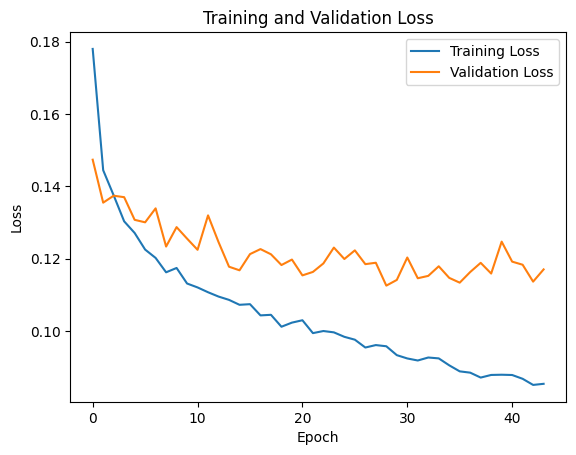

In [45]:
import matplotlib.pyplot as plt
import numpy as np

loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, train_loss_list, label='Training Loss')
plt.plot(loss, val_loss_list, label='Validation Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Draw chart for train dataset

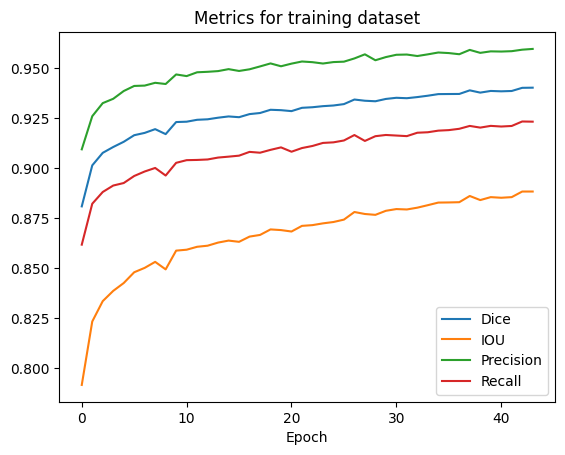

In [46]:
loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, train_dice_loss, label='Dice') 
plt.plot(loss, train_iou_loss, label='IOU') 
plt.plot(loss, train_precision_loss, label='Precision') 
plt.plot(loss, train_recall_loss, label='Recall') 
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics for training dataset')
plt.legend()
plt.show()


### Draw chart for validation dataset

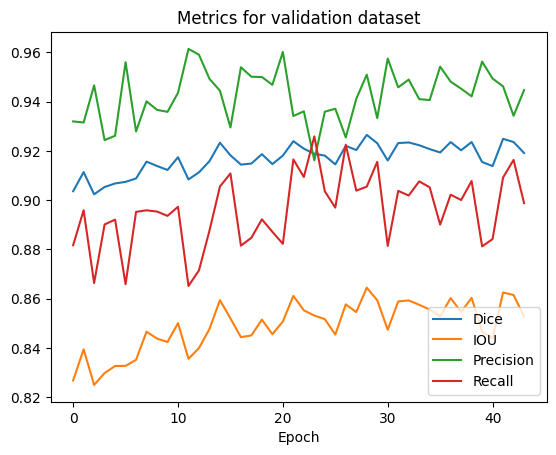

In [47]:
loss = np.arange(epoch + 1)

# Biểu đồ mean loss
plt.plot(loss, val_dice_loss, label='Dice') 
plt.plot(loss, val_iou_loss, label='IOU') 
plt.plot(loss, val_precision_loss, label='Precision') 
plt.plot(loss, val_recall_loss, label='Recall') 
plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics for validation dataset')
plt.legend()
plt.show()


### Đánh giá trọng số mô hình với tập Test Dataset (IOU, Precision, Recall, Dice)

In [48]:
# # Check if GPU is available, otherwise use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move model to the device
# model.to(device)

# # Tải trọng số từ checkpoint
# checkpoint_path = "/kaggle/input/validation-100epochs/checkpoint_SAM/best_model_weights.pt"
# checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# # Load trọng số vào mô hình
# model.load_state_dict(checkpoint)

# # Đặt mô hình vào chế độ đánh giá
# model.eval()

# # Tiếp tục quá trình kiểm tra mô hình như đã thực hiện trước đó
# val_dice_scores = []
# val_iou_scores = []
# val_recall_scores = []
# val_precision_scores = []

# with torch.no_grad():
#     for batch in tqdm(val_dataloader):
#         # Forward pass
#         outputs = model(pixel_values=batch["pixel_values"].to(device),
#                         input_boxes=batch["input_boxes"].to(device),
#                         multimask_output=False)

#         # Compute evaluation metrics
#         predicted_masks = (outputs.pred_masks.squeeze() > 0.5).float() 
#         ground_truth_masks = batch["ground_truth_mask"].float().to(device)

#         val_dice_scores.append(dice(predicted_masks, ground_truth_masks))
#         val_iou_scores.append(iou(predicted_masks, ground_truth_masks))
#         val_recall_scores.append(recall(predicted_masks, ground_truth_masks))
#         val_precision_scores.append(precision(predicted_masks, ground_truth_masks))

# # Print evaluation metrics
# print("\n")
# print(f'Validation Dice: {torch.tensor(val_dice_scores).mean().item():.4f}')
# print(f'Validation IOU: {torch.tensor(val_iou_scores).mean().item():.4f}')
# print(f'Validation Recall: {torch.tensor(val_recall_scores).mean().item():.4f}')
# print(f'Validation Precision: {torch.tensor(val_precision_scores).mean().item():.4f}')


In [49]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Tải trọng số từ checkpoint
checkpoint_path = "/kaggle/input/validation-100epochs/checkpoint_SAM/best_model_weights.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load trọng số vào mô hình
model.load_state_dict(checkpoint)

# Đặt mô hình vào chế độ đánh giá
model.eval()

# Tiếp tục quá trình kiểm tra mô hình như đã thực hiện trước đó
test_dice_scores = []
test_iou_scores = []
test_recall_scores = []
test_precision_scores = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute evaluation metrics
        predicted_masks = (torch.sigmoid(outputs['pred_masks']).squeeze() > 0.5).float()
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        test_dice_scores.append(dice(predicted_masks, ground_truth_masks))
        test_iou_scores.append(iou(predicted_masks, ground_truth_masks))
        test_recall_scores.append(recall(predicted_masks, ground_truth_masks))
        test_precision_scores.append(precision(predicted_masks, ground_truth_masks))

# Print evaluation metrics
print("\n")
print(f'Test Dice: {torch.tensor(test_dice_scores).mean().item():.4f}')
print(f'Test IOU: {torch.tensor(test_iou_scores).mean().item():.4f}')
print(f'Test Recall: {torch.tensor(test_recall_scores).mean().item():.4f}')
print(f'Test Precision: {torch.tensor(test_precision_scores).mean().item():.4f}')

100%|██████████| 73/73 [00:43<00:00,  1.68it/s]



Test Dice: 0.9233
Test IOU: 0.8597
Test Recall: 0.9330
Test Precision: 0.9169


### Train tiếp model từ trọng số

## Kiểm thử mô hình

In [50]:
# import numpy as np
# from PIL import Image

# # let's take a random training example
# idx = 100

# # load image
# image = test_dataset[idx]["image"]
# image

In [51]:
# import torch
# # Sử dụng GPU nếu có sẵn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # get box prompt based on ground truth segmentation map
# ground_truth_mask = np.array(test_dataset[idx]["label"])
# prompt = get_bounding_box(ground_truth_mask)

# # prepare image + box prompt for the model
# inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
# for k,v in inputs.items():
#   print(k,v.shape)

In [52]:
# model.eval()

# # forward pass
# with torch.no_grad():
#   outputs = model(**inputs, multimask_output=False)

In [53]:
# # apply sigmoid
# medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# # convert soft mask to hard mask
# medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
# medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [54]:
# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)

In [55]:
# import numpy as np
# from PIL import Image
# import torch
# import matplotlib.pyplot as plt

# # Sử dụng GPU nếu có sẵn
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for idx in range(0, len(test_dataset)):  # Duyệt qua các chỉ số từ 1 đến 10
#     # load image
#     image = test_dataset[idx]["image"]

#     # get box prompt based on ground truth segmentation map
#     ground_truth_mask = np.array(test_dataset[idx]["label"])
#     prompt = get_bounding_box(ground_truth_mask)

#     # prepare image + box prompt for the model
#     inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)

#     model.eval()

#     # forward pass
#     with torch.no_grad():
#         outputs = model(**inputs, multimask_output=False)

#     # apply sigmoid
#     medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
#     # convert soft mask to hard mask
#     medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
#     medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
#     fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#     # Hiển thị hình ảnh
#     axes[0].imshow(image)
#     axes[0].set_title("Image")
#     axes[0].axis("off")

#     # Hiển thị đồ thị cho ground truth mask
#     axes[1].imshow(ground_truth_mask)
#     axes[1].set_title("Ground truth mask")
#     axes[1].axis("off")

#     # Hiển thị đồ thị cho predicted mask
#     axes[2].imshow(medsam_seg)
#     axes[2].set_title("Predicted mask")
#     axes[2].axis("off")

#     plt.show()